## Use the wetlands insight tool as supervision data to associate labels with the unsupervised clusters

In [1]:
#imports
%matplotlib inline
import numpy as np
import datacube
import matplotlib.pyplot as plt
import radar_functions as rf
import radar_gmm as rg
import fiona
from datacube.utils import geometry
import rasterio.features

import xarray as xr

# Import external functions from dea-notebooks
import sys
sys.path.append('./10_Scripts/')
import DEAPlotting, TasseledCapTools, wetlands_insight
#setup radar dc
dc = datacube.Datacube(config='radar.conf')

In [443]:
import imp
imp.reload(rg)

<module 'radar_gmm' from '/g/data1a/r78/rlt118/dea-notebooks/radar_gmm.py'>

In [44]:
#use this cell when editing scripts frequently
%load_ext autoreload
%autoreload 0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
#define the region of interest
qtime = ('2016-01-01', '2019-01-01')

# query = {
#          'time': qtime,
#          'lat': (-30.76,-30.62),
#          'long': (147.50,147.60)
#          }

query = {
         'time': qtime,
         'lat': (-12.70,-12.64),
         'long': (132.53,132.64)
         }


allSAR = rf.load_cleaned_SAR(query,dc,incidence_angle=False)


In [3]:
#something weird going on with this scene (only for mac marshes)
allSAR = allSAR.drop(allSAR.time[62].data,dim='time')

In [3]:
bulknormSAR = rf.bulknorm_SAR_ds(np.log(allSAR))

In [4]:
downsampled = rf.downsample_ds(bulknormSAR)

/g/data/v10/public/modules/dea-env/20190709/lib/python3.6/site-packages/xarray/core/nanops.py:160: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [ ]:
down_cover = rf.downsample_ds(optical_cover)

In [12]:
%load_ext autoreload

In [13]:
%autoreload 2
model = rg.SAR_Ktree()
model.fit(downsampled)

In [92]:
model = rg.SAR_Ktree()

In [ ]:
model.fit(bulknormSAR)

In [245]:
model.landcover_dict=None

In [65]:
errmat = np.array([
        [0.0,0.0,1.2,0.9,1.0],
        [0.1,0.0,1.5,0.6,0.9],
        [0.9,1.2,0,0.8,0.4],
        [0.8,0.0,1.0,0.0,1.2],
        [0.7,1.7,0.2,0.8,0.0]
    ])

In [66]:
model.assoc(bulknormSAR,optical_cover, error_matrix=errmat)

In [67]:
model.landcover_dict

array([0, 1, 0, 3, 2, 3, 4, 1, 4])

In [486]:
model.landcover_dict = None

In [68]:
all_out = model.predict_dataset(bulknormSAR)

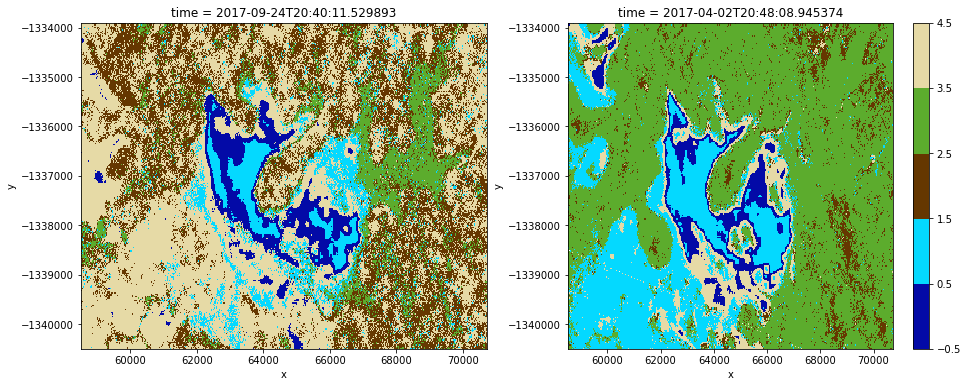

In [69]:
#plot 
import seaborn as sns
pal = [
       sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["brown"],
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"]
       ]
tind1=58
tind2=34
fig,ax=plt.subplots(1,2,figsize=(16,6))
#(all_out.isel(time=tind1)).plot(vmin=0,vmax=8.01,cmap='tab20',levels=10,ax=ax[0])
#(all_out.isel(time=tind2)).plot(vmin=0,vmax=8.01,cmap='tab20',levels=10,ax=ax[1])

#fig,ax=plt.subplots(1,2,figsize=(16,12))
(all_out.isel(time=tind1)).plot(vmin=-0.5,vmax=4.5,colors=pal,levels=6,ax=ax[0],add_colorbar=False)
(all_out.isel(time=tind2)).plot(vmin=-0.5,vmax=4.5,colors=pal,levels=6,ax=ax[1],add_colorbar=True)


In [70]:
t,ts = rg.tree_timeseries(bulknormSAR,model)

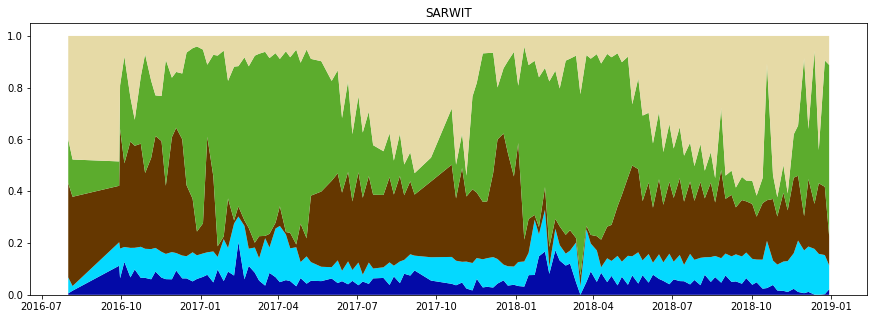

In [71]:
plt.figure(figsize=(15,5));plt.title('SARWIT')
plt.stackplot(t.data,ts.transpose(),colors=pal)

In [9]:
optical_cover = wetlands_insight.WIT_da(query)

Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 42 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)
Loading ls5
    Skipping ls5; no valid data for query
Loading ls7
    Ignoring SLC-off observations for ls7
    Skipping ls7; no valid data for query
Loading ls8
    Loading 42 filtered ls8 timesteps
Returning ls8 data
    Replacing invalid -999 values with NaN (data will be coerced to float64)


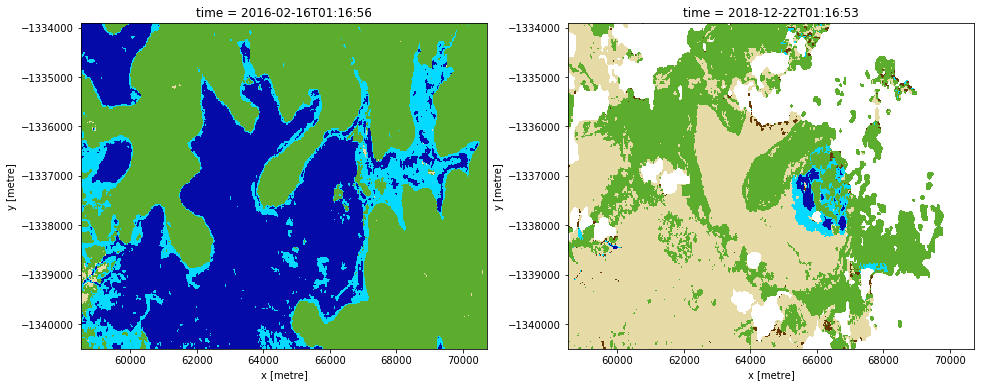

In [149]:
pal_opt = [sns.xkcd_rgb["cobalt blue"],
       sns.xkcd_rgb["neon blue"],
       sns.xkcd_rgb["brown"],  
       sns.xkcd_rgb["grass"],
       sns.xkcd_rgb["beige"]]
fig,ax = plt.subplots(1,2,figsize=(16,6))
optical_cover.isel(time=1).plot(vmin = 0, vmax = 4.01, levels=6, colors = pal_opt, add_colorbar=False,ax=ax[0])
optical_cover.isel(time=41).plot(vmin = 0, vmax = 4.01, levels=6, colors = pal_opt, add_colorbar=False,ax=ax[1])

We can reindex the SAR cluster images to match the WIT maps and then use this to associate labels with each cluster

In [66]:
association_input = all_out.reindex(time=optical_cover.time,method='nearest',tolerance=np.timedelta64(2,'D'))

In [159]:
imp.reload(rg)

<module 'radar_gmm' from '/g/data1a/r78/rlt118/dea-notebooks/radar_gmm.py'>

In [67]:
import fastmode

In [154]:
b = np.array([5,6,7,8,9,8,8,9,10])
a = b==8

In [157]:
b[a] = [1,2,3]

In [158]:
b

array([ 5,  6,  7,  1,  9,  2,  3,  9, 10])

In [70]:
cover_dict = np.zeros(9)
for clus in np.arange(9):
    WIT_labels = optical_cover.where(association_input==clus)
    cover_dict[clus] = fastmode.mode_class(WIT_labels,num_classes=5)

In [71]:
cover_dict

array([4., 4., 4., 3., 3., 3., 4., 1., 3.])

In [152]:
np.full(8,3)

array([3, 3, 3, 3, 3, 3, 3, 3])

In [146]:
model.landcover_dict = cover_dict

In [147]:
cover_out = model.predict_dataset(bulknormSAR)

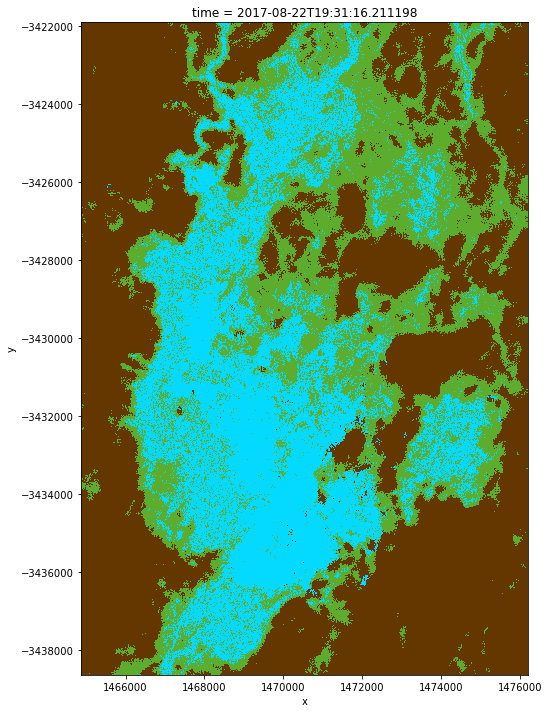

In [148]:
cover_out.isel(time=46).plot(vmin = 0, vmax = 4.01, levels=6, colors = pal_opt, add_colorbar=False,figsize=(8,12))

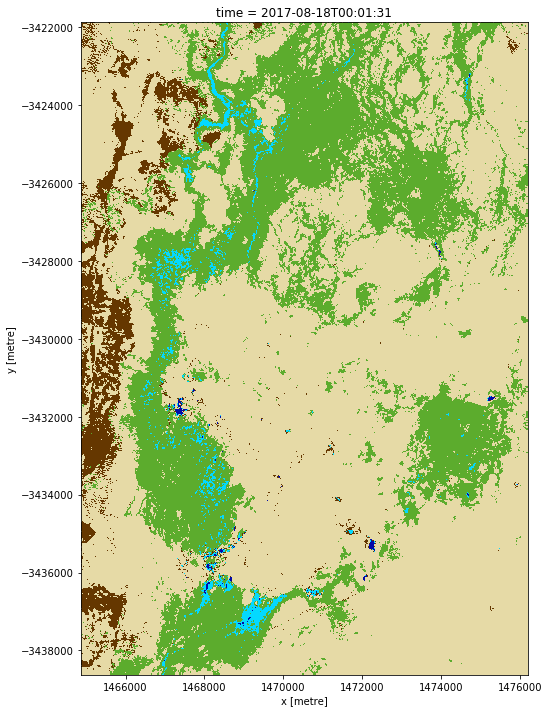

In [54]:
optical_cover.isel(time=33).plot(vmin = 0, vmax = 4.01, levels=6, colors = pal_opt, add_colorbar=False,figsize=(8,12))

In [49]:
imp.reload(rg)

<module 'radar_gmm' from '/g/data1a/r78/rlt118/dea-notebooks/radar_gmm.py'>

We need some kind of 'weighted mode' for each class based on its prevalence in the training labels. We can get the weights simply:

In [140]:
used_cover = optical_cover.where(~np.isnan(association_input))
weights = 1./np.array([(used_cover==cla).sum() for cla in range(5)])
weights = weights/weights.sum()

#we don't want to amplify signals that basically aren't there
weights[weights > 0.4] = 0
weights = weights/weights.sum()

In [141]:
weights

array([0.        , 0.40589852, 0.43712583, 0.07000706, 0.08696859])

We can now redo the cover dictionary with the weights included:

In [142]:
cover_dict = np.zeros(9)
for clus in np.arange(9):
    WIT_labels = optical_cover.where(association_input==clus)
    cover_dict[clus] = fastmode.mode_class(WIT_labels,num_classes=5,weights=weights)

In [69]:
import imp;imp.reload(fastmode)

<module 'fastmode' from '/g/data1a/r78/rlt118/dea-notebooks/fastmode.py'>

In [143]:
cover_dict

array([2., 2., 2., 3., 1., 3., 1., 1., 1.])

In [44]:
a = np.array([0,1.5])